## In v0.2, model was trained on all data.  This may be why model overestimates.  Retrain with data filtered for waittime values below threshold.

* Remove start/end from init()
* Add filtering after neighbors created in prepare_source()

In [41]:
from datetime import date, datetime
from BorderModel import BorderImpute, emulate_testdata
from sklearn.ensemble import ExtraTreesRegressor
from dbhelper import pd_query
import matplotlib.pyplot as plt
import random
from sklearn.metrics import r2_score
import pandas as pd
from scipy.stats import ttest_ind
%matplotlib inline

# Get source data with neighbor features
source_query = '''
               select 
                   c.date,
                   year,
                   month,
                   dayofweek,
                   minofday,
                   metric as volume,
                   waittime
               from crossingdata c
               join datefeatures d
                   on d.date = c.date
               join mungedata m 
                   on m.date = c.date
                   and m.crossing_id = c.crossing_id
                   and munger_id = 2
                   and is_waittime = false
                   and metric is not null
               where
                   c.crossing_id=1
                   and valid = 1
                   and waittime is not null
                order by c.date;
               '''
source_df = pd_query(source_query)

target_query = '''
               select 
                   c.date,
                   year,
                   month,
                   dayofweek,
                   minofday,
                   metric as volume,
                   waittime
               from crossingdata c
               join datefeatures d
                   on d.date = c.date
               join mungedata m 
                   on m.date = c.date
                   and m.crossing_id = c.crossing_id
                   and munger_id = 2
                   and is_waittime = false
                   and metric is not null
               where
                   c.crossing_id=5
                   and valid = 1
                   and waittime is not null
                order by c.date;
               '''

target_df = pd_query(target_query)

In [53]:
def run_impute(threshold, window, source_df, target_df):
    imputer = BorderImpute(threshold=threshold, window=window, progressbar=False)

    dfsource = imputer.prepare_source(source_df)
    model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, bootstrap=True, oob_score=True)
    imputer.build_model(model)

    imputer.prepare_target(emulate_testdata(target_df))
    imputer.predict()
    
    return imputer

def imputer_score(imputer, target_df):    
    return r2_score(target_df.set_index('date')[pd.isnull(imputer.targetdf.waittime)].waittime,
                    imputer.predictdf[pd.isnull(imputer.targetdf.waittime)].waittime)

def plot_imputed(imputer, target_df, start, end):
    plt.figure(figsize=(18,4))
#     plt.plot(target_df[(target_df.date >= start) & (target_df.date < end)].set_index('date').waittime, label='actual')
#     plt.plot(imputer.predictdf[(imputer.predictdf.index >= start) & (imputer.predictdf.index < end)].waittime, label='predict')
    target_df = target_df.set_index('date')
    plt.plot(target_df[start:end].waittime, label='actual')
    plt.plot(imputer.predictdf[start:end].waittime, label='predict')
    plt.legend();
    
def imputer_stats(imputer, target_df):
    df = pd.DataFrame()
    df['predict'] = imputer.predictdf[imputer.predictdf.waittime < imputer.threshold].waittime
    temp = target_df.set_index('date')
    df['actual'] = temp[temp.waittime < imputer.threshold].waittime
    print df.describe().T
    print ttest_ind(df.predict, df.actual, equal_var=False)
    plt.hist(df.predict, alpha=.3, label='predict')
    plt.hist(df.actual, alpha=.3, label='actual')
    plt.legend();

In [3]:
imp = {}

for window in [24, 32, 48, 60]:
    imp[window] = run_impute(10, window, source_df, target_df)
    print imputer_score(imp[window], target_df)

123539
26891
3194
74
0
-0.21199849925
81401
7060
80
0
-0.260339463914
25894
169
0
-0.356392252325


KeyboardInterrupt: 

In [4]:
for window in [6, 12]:
    imp[window] = run_impute(10, window, source_df, target_df)
    print imputer_score(imp[window], target_df)

275203
205883
160591
123163
90271
62480
41190
26072
16185
9662
5590
3100
1680
855
391
138
35
8
0
-0.03867556696
204980
121688
61137
25246
9317
3019
762
152
38
4
0
-0.158041491031


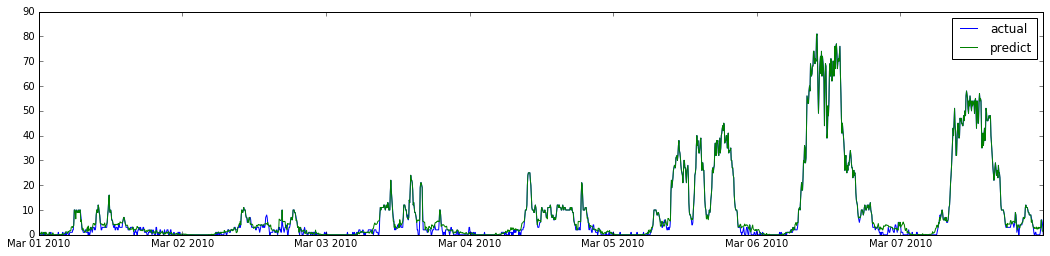

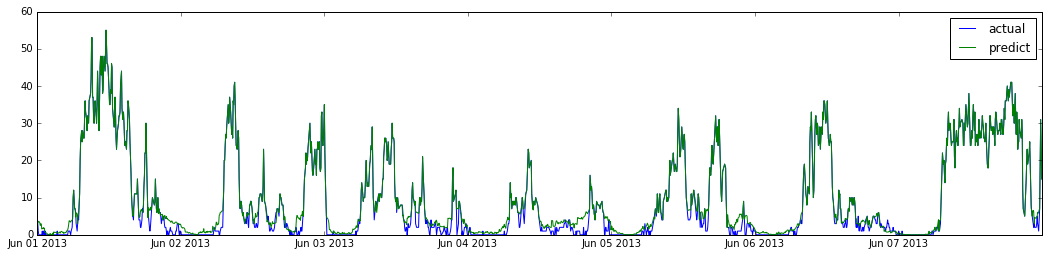

In [10]:
plot_imputed(imp[6], target_df, '2010-03-01', '2010-03-08')
plot_imputed(imp[6], target_df, '2013-06-01', '2013-06-08')

## Try scaling training data

In [11]:
source_query_scale = '''
               select 
                   c.date,
                   year,
                   month,
                   dayofweek,
                   minofday,
                   metric * 9.8/13.9 as volume,
                   waittime * 10.7/12.5 as waittime
               from crossingdata c
               join datefeatures d
                   on d.date = c.date
               join mungedata m 
                   on m.date = c.date
                   and m.crossing_id = c.crossing_id
                   and munger_id = 2
                   and is_waittime = false
                   and metric is not null
               where
                   c.crossing_id=1
                   and valid = 1
                   and waittime is not null
                order by c.date;
               '''

source_df_scaled = pd_query(source_query_scale)

In [12]:
for window in [6, 12]:
    imp[window] = run_impute(10, window, source_df_scaled, target_df)
    print imputer_score(imp[window], target_df)

275656
206161
160777
122941
89860
61949
40428
25382
15364
9072
5134
2846
1546
813
408
236
156
99
60
36
12
0
-0.229137080184
205549
122601
61757
25860
9478
2890
830
234
42
17
0
-0.318284976458


### As we saw in earlier analysis, scaling of training data does not help.  This suggests that there is a true relationship between waittime and volume at values under a threshold.

## Perhaps a question to ask is: Is r2 = 0 bad?  
* 0 implies the model is equivalent to predicting the mean
* Since we had no data, it is actually not bad to be able to do as well as guessing the mean.

### Let's look at summary stats of  imputed data vs actual

In [13]:
for window in [6, 8, 10]:
    imp[window] = run_impute(10, window, source_df, target_df)
    print imputer_score(imp[window], target_df)

275468
206716
161192
123509
90522
62637
41418
26244
16176
9681
5506
3023
1660
868
417
148
66
27
3
0
-0.0329361316413
246691
174560
122701
79513
46773
25802
13442
6626
2958
1095
387
105
12
0
-0.0891809877318
224944
146921
89547
47160
22307
9710
3745
1270
418
139
48
8
0
-0.163185633636


          count      mean       std  min       25%       50%      75%  max
predict  552702  2.555803  2.393401    0  0.604167  1.916667  3.84375    9
actual   552702  1.819715  2.460851    0  0.000000  1.000000  3.00000    9
Ttest_indResult(statistic=159.41386594503169, pvalue=0.0)


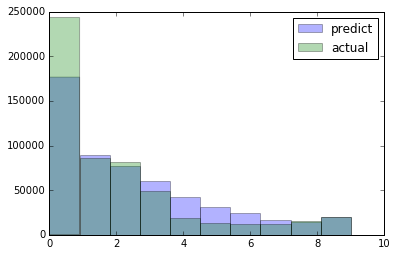

In [54]:
imputer_stats(imp[6], target_df)

## In general, the imputer will bias the wait time to be higher than true value, but the difference is small enough.